In [1]:
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
from qcodes.instrument.base import InstrumentBase
from qdev_wrappers.customised_instruments.interfaces.AWG_interface import SimulatedAWGInterface, AWG5014Interface
from lomentum.loader import read_element
from lomentum.plotting import plotter
from lomentum import in_context, Sequence
import yaml

In [2]:
def print_params(instr):
    print(instr.name.upper())
    for k, v in instr.parameters.items():
        if k != 'IDN':
            print(k, ': ', v())
    for k, v in instr.submodules.items():
        if isinstance(v, InstrumentBase):
            print('\n')
            print_params(v)

### AWG Interface

Available parameters include the amplitudes on each physical channel, the sample rate, the sleep time (a hack parameter meant to catch the fact that the AWG5014C takes longer than it thinks it does to respond to commands), the sequence mode ('sequence' means the whole sequence is played one element after another, 'element' means one single element is played) and repetition mode ('inf' means the sequence or element is played infinitely, 'single' means it is played only once).

In [3]:
simulated_awg_if = SimulatedAWGInterface('simulated_awg')

In [4]:
print_params(simulated_awg_if)

SIMULATED_AWG
sample_rate :  1000000000.0
sequence_mode :  sequence
repetition_mode :  inf
sleep_time :  0


SIMULATED_AWG_CH0
Vpp :  1


SIMULATED_AWG_CH1
Vpp :  1


SIMULATED_AWG_CH2
Vpp :  1


SIMULATED_AWG_CH3
Vpp :  1


Load a template element, create a sequence and plot it:

In [5]:
with open('linear_element.yaml') as f:
    yf = yaml.safe_load(f)
    template_element = read_element(yf)

In [6]:
context = {'total_duration': 20e-6,
           'driving_stage_duration': 10e-6,
           'readout_pulse_duration': 5e-6,
           'readout_marker_duration': 50e-9,
           'gate_pulse_duration': 2e-6,
           'drive_pulse_amplitude': 1,
           'drive_sideband_frequency': 1e6,
           'marker_readout_delay': 100e-9,
           'drive_readout_delay': 0}

In [7]:
elements = []
for i in range(5):
    elements.append(in_context(template_element, drive_pulse_amplitude=i))
seq = Sequence(elements)
forged_sequence = seq.forge(SR=simulated_awg_if.sample_rate(), context=context)

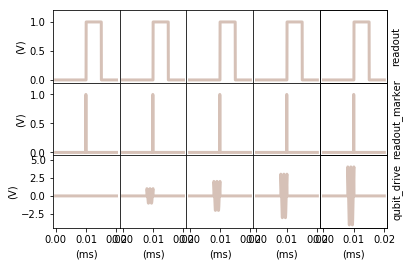

In [8]:
plotter(forged_sequence, SR=simulated_awg_if.sample_rate())

Upload to simulated awg. Since the sequence_mode is in 'sequence' and the repetition_mode is in 'inf' the full sequence will be set up to run infinitely and will run (if the repetition_mode is 'single' then it will only run when the run runciton is called).

uploading
running


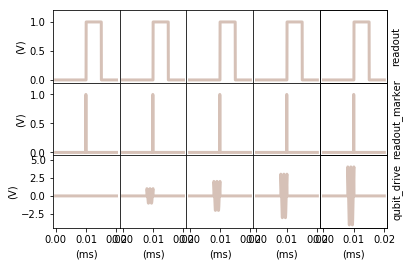

In [9]:
simulated_awg_if.upload(forged_sequence)

We can choose to run one particular element. In doing this we change the sequence_mode to 'element' but the repetition_mode is preserved and the element immediately begins to run.

setting element to 3
running


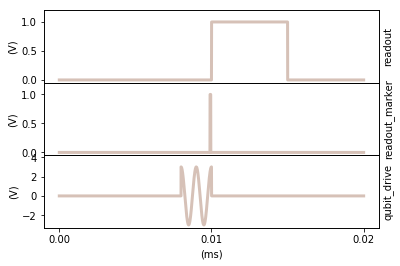

In [10]:
simulated_awg_if.set_element(3)

In [14]:
print(simulated_awg_if.sequence_mode())
print(simulated_awg_if.repetition_mode())

element
inf


Of course these can also be changed independently:

setting sequence_mode to sequence
running


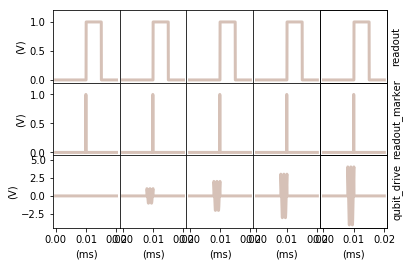

In [12]:
simulated_awg_if.sequence_mode('sequence')

Changing back to element will remember the most recent element run.

setting sequence_mode to element
setting element to 3
running


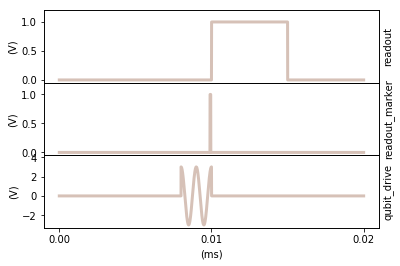

In [13]:
simulated_awg_if.sequence_mode('element')

In [15]:
simulated_awg_if.repetition_mode('single')

setting repetition_mode to single


In [16]:
simulated_awg_if.repetition_mode('inf')

setting repetition_mode to inf
running


### Now with a real awg...
Use an oscilloscope to check it's doing what you think it's doing ;)

In [ ]:
awg_instrument = Tektronix_AWG5014('awg', '')
real_awg_if = AWG5014Interface('real_awg', awg_instrument)

In [ ]:
print_params(real_awg_if)

In [ ]:
real_awg_if.upload(forged_sequence)

In [ ]:
real_awg_if.set_element(3)

In [ ]:
real_awg_if.sequence_mode('sequence')

In [ ]:
real_awg_if.repetition_mode('single')

In [ ]:
real_awg_if.run()

In [ ]:
real_awg_if.repetition_mode('inf')

In [ ]:
real_awg_if.sequence_mode('element')